In [1]:
import os
os.environ["R_HOME"] = "/home/kgr851/.conda/envs/bulkATAC_RNA/lib/R"

# ============================================================
# 1) Warnings / display defaults
# ============================================================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ============================================================
# 2) Core Python libs
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 3) Plotting style
# ============================================================
sns.set_context("talk")
sns.set(rc={"figure.figsize": (4, 3.5), "figure.dpi": 200})
sns.set_style("whitegrid")
plt.rcParams["pdf.fonttype"] = 42  # editable text in Illustrator

# ============================================================
# 4) R in Jupyter (rpy2)
# ============================================================
%load_ext rpy2.ipython

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Use the modern context-based approach to avoid deprecation warning
# This replaces the deprecated pandas2ri.activate() call

import pandas as pd
import numpy as np
import re
from pathlib import Path

In [2]:
import os
os.environ["R_HOME"] = "/home/kgr851/.conda/envs/bulkATAC_RNA/lib/R"

# ============================================================
# 1) Warnings / display defaults
# ============================================================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ============================================================
# 2) Core Python libs
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 3) Plotting style
# ============================================================
sns.set_context("talk")
sns.set(rc={"figure.figsize": (4, 3.5), "figure.dpi": 200})
sns.set_style("whitegrid")
plt.rcParams["pdf.fonttype"] = 42  # editable text in Illustrator

# ============================================================
# 4) R in Jupyter (rpy2)
# ============================================================
%load_ext rpy2.ipython

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Use the modern context-based approach to avoid deprecation warning
# This replaces the deprecated pandas2ri.activate() call

import pandas as pd
import numpy as np
import re
from pathlib import Path

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE = Path("/home/kgr851/BULK_RNA")
COUNTS_INT = BASE / "RNA_counts_all_INT.csv"
META_CSV   = BASE / "RNA_metadata_all.csv"
GENE_MAP   = BASE / "gene_id_to_name.csv"   # gene_id,gene_name

# ---- 1) load inputs
counts = pd.read_csv(COUNTS_INT, index_col=0)     # rows: gene_id, cols: sample
meta   = pd.read_csv(META_CSV)                   # must include 'sample'
gene_map = pd.read_csv(GENE_MAP).drop_duplicates("gene_id")

# keep only samples we have in meta (and in the same order as meta)
meta = meta.copy()
meta["sample"] = meta["sample"].astype(str)

missing = [s for s in meta["sample"].tolist() if s not in counts.columns]
if missing:
    raise ValueError(f"{len(missing)} samples in meta not found in counts. Example: {missing[:10]}")

counts = counts.loc[:, meta["sample"].tolist()]

print("counts:", counts.shape, "meta:", meta.shape, "gene_map:", gene_map.shape)
meta.head()

counts: (62812, 64) meta: (64, 5) gene_map: (62812, 2)


,sample,cellline,time,fate,replicate
0,H9_0h_undiff_Rep1,H9,0h,undiff,1
1,H9_0h_undiff_Rep2,H9,0h,undiff,2
2,H9_12h_FB_Rep1,H9,12h,FB,1
3,H9_12h_FB_Rep2,H9,12h,FB,2
4,H9_12h_HB_Rep1,H9,12h,HB,1


In [4]:
meta.groupby(["time","cellline"])['sample'].nunique()

time  cellline
0h    H9           2
12h   H9           6
24h   H9           6
3d    H9           6
48h   H9           6
      KOLF         6
      RC17         6
5d    H9          10
      KOLF         8
      RC17         8
Name: sample, dtype: int64

In [5]:
meta.groupby(["time","cellline","fate"])["sample"].nunique().sort_index()

time  cellline  fate  
0h    H9        undiff    2
12h   H9        FB        2
                HB        2
                MB        2
24h   H9        FB        2
                HB        2
                MB        2
3d    H9        FB        2
                HB        2
                MB        2
48h   H9        FB        2
                HB        2
                MB        2
      KOLF      FB        2
                HB        2
                MB        2
      RC17      FB        2
                HB        2
                MB        2
5d    H9        FB        2
                FB_HB     2
                HB        2
                HB_FB     2
                MB        2
      KOLF      FB        2
                FB_HB     2
                HB        2
                HB_FB     2
      RC17      FB        2
                FB_HB     2
                HB        2
                HB_FB     2
Name: sample, dtype: int64

# Cell 2 (Python) — Ensure required metadata columns + write to disk for R

In [6]:
# Required columns for the downstream plotting
required = ["sample", "time", "fate", "cellline"]
missing_cols = [c for c in required if c not in meta.columns]
if missing_cols:
    raise ValueError(f"RNA_metadata_all.csv missing required columns: {missing_cols}")

# enforce string sample ids
meta["sample"] = meta["sample"].astype(str)

# output files for DESeq2
OUTDIR = BASE / "timeline_plots"
OUTDIR.mkdir(parents=True, exist_ok=True)

R_COUNTS = OUTDIR / "counts_for_deseq2.tsv"  # gene_id + sample columns
R_META   = OUTDIR / "meta_for_deseq2.tsv"    # sample + covariates
VST_TSV  = OUTDIR / "vst_deseq2.tsv"         # gene_id + vst columns

# write counts with gene_id as first column
counts_out = counts.copy()
counts_out.insert(0, "gene_id", counts_out.index.astype(str))
counts_out.to_csv(R_COUNTS, sep="\t", index=False)

# write meta with sample as first column (R will use it as rownames)
meta_out = meta.copy()
meta_out.to_csv(R_META, sep="\t", index=False)

print("Wrote:", R_COUNTS)
print("Wrote:", R_META)
print("Will write:", VST_TSV)

Wrote: /home/kgr851/BULK_RNA/timeline_plots/counts_for_deseq2.tsv
Wrote: /home/kgr851/BULK_RNA/timeline_plots/meta_for_deseq2.tsv
Will write: /home/kgr851/BULK_RNA/timeline_plots/vst_deseq2.tsv


# Cell 3 (R) — DESeq2 VST (the ONLY VST)

In [7]:
# Required columns for the downstream plotting
required = ["sample", "time", "fate", "cellline"]
missing_cols = [c for c in required if c not in meta.columns]
if missing_cols:
    raise ValueError(f"RNA_metadata_all.csv missing required columns: {missing_cols}")

# enforce string sample ids
meta["sample"] = meta["sample"].astype(str)

# output files for DESeq2
OUTDIR = BASE / "timeline_plots"
OUTDIR.mkdir(parents=True, exist_ok=True)

R_COUNTS = OUTDIR / "counts_for_deseq2.tsv"  # gene_id + sample columns
R_META   = OUTDIR / "meta_for_deseq2.tsv"    # sample + covariates
VST_TSV  = OUTDIR / "vst_deseq2.tsv"         # gene_id + vst columns

# write counts with gene_id as first column
counts_out = counts.copy()
counts_out.insert(0, "gene_id", counts_out.index.astype(str))
counts_out.to_csv(R_COUNTS, sep="\t", index=False)

# write meta with sample as first column (R will use it as rownames)
meta_out = meta.copy()
meta_out.to_csv(R_META, sep="\t", index=False)

print("Wrote:", R_COUNTS)
print("Wrote:", R_META)
print("Will write:", VST_TSV)

Wrote: /home/kgr851/BULK_RNA/timeline_plots/counts_for_deseq2.tsv
Wrote: /home/kgr851/BULK_RNA/timeline_plots/meta_for_deseq2.tsv
Will write: /home/kgr851/BULK_RNA/timeline_plots/vst_deseq2.tsv


# Cell 4 (Python) — Load VST + attach gene names

In [8]:
vst = pd.read_csv(VST_TSV, sep="\t")
vst = vst.set_index("gene_id")

# attach gene_name if available
gm = gene_map[["gene_id", "gene_name"]].copy()
gm["gene_id"] = gm["gene_id"].astype(str)

vst.index = vst.index.astype(str)
vst = vst.merge(gm.set_index("gene_id"), left_index=True, right_index=True, how="left")

# Move gene_name to a column and keep vst matrix separate when needed
gene_name = vst["gene_name"].copy()
vst_mat = vst.drop(columns=["gene_name"])

print("VST matrix:", vst_mat.shape, "gene_name mapped:", gene_name.notna().mean())
vst_mat.iloc[:5, :5]

VST matrix: (33969, 64) gene_name mapped: 1.0


,H9_0h_undiff_Rep1,H9_0h_undiff_Rep2,H9_12h_FB_Rep1,H9_12h_FB_Rep2,H9_12h_HB_Rep1
gene_id,,,,,
ENSG00000000003,9.405302,9.786512,9.779555,9.781325,9.855933
ENSG00000000005,6.260569,6.291198,5.873242,5.803021,5.768672
ENSG00000000419,9.688805,9.727659,9.616649,9.778983,10.067952
ENSG00000000457,7.656313,7.625724,7.666785,7.824243,7.647551
ENSG00000000460,8.808981,8.856626,8.792899,8.953198,8.705052


In [9]:
# Cell 5 (Python) — Build tidy dataframe for plotting

In [10]:
TIME_ORDER = ["12h", "24h", "48h", "3d", "5d"]
KEEP_FATES = ["FB", "HB", "MB"]

# Build long df: gene_id x sample -> long + merge meta + gene_name
df = (
    vst_mat.reset_index(names="gene_id")
    .melt(id_vars="gene_id", var_name="sample", value_name="vst")
    .merge(meta, on="sample", how="left")
)

df = df.merge(gene_map[["gene_id", "gene_name"]], on="gene_id", how="left")

# Filter to the timeline window + desired fates
df_plot = df[
    (df["fate"].isin(KEEP_FATES)) &
    (df["time"].astype(str).isin(TIME_ORDER))
].copy()

# Order time for stable plotting
df_plot["time"] = pd.Categorical(df_plot["time"].astype(str), categories=TIME_ORDER, ordered=True)

print("Samples per fate x time:")
print(meta[meta["fate"].isin(KEEP_FATES)].groupby(["fate","time"])["sample"].nunique().sort_index())
df_plot.head()

Samples per fate x time:
fate  time
FB    12h     2
      24h     2
      3d      2
      48h     6
      5d      6
HB    12h     2
      24h     2
      3d      2
      48h     6
      5d      6
MB    12h     2
      24h     2
      3d      2
      48h     6
      5d      2
Name: sample, dtype: int64


,gene_id,sample,vst,cellline,time,fate,replicate,gene_name
67938,ENSG00000000003,H9_12h_FB_Rep1,9.779555,H9,12h,FB,1,TSPAN6
67939,ENSG00000000005,H9_12h_FB_Rep1,5.873242,H9,12h,FB,1,TNMD
67940,ENSG00000000419,H9_12h_FB_Rep1,9.616649,H9,12h,FB,1,DPM1
67941,ENSG00000000457,H9_12h_FB_Rep1,7.666785,H9,12h,FB,1,SCYL3
67942,ENSG00000000460,H9_12h_FB_Rep1,8.792899,H9,12h,FB,1,FIRRM


# Helper to resolve  gene list (names → gene_id rows)

In [11]:
def resolve_genes(gene_list, gene_map, allow_partial=True):
    """
    Returns:
      - resolved: list of gene_name strings that exist in gene_map
      - missing: list of gene_name strings not found
    Matching is case-insensitive (OTX2 == otx2).
    """
    gm = gene_map.copy()
    gm["gene_name"] = gm["gene_name"].astype(str)
    name_set = set(gm["gene_name"])
    name_upper = {n.upper(): n for n in name_set}

    resolved = []
    missing = []
    for g in gene_list:
        g0 = str(g)
        hit = name_upper.get(g0.upper(), None)
        if hit is None:
            missing.append(g0)
        else:
            resolved.append(hit)

    if (not allow_partial) and missing:
        raise ValueError(f"Missing genes: {missing}")

    return resolved, missing

In [12]:
TIME_ORDER_0H = ["0h", "12h", "24h", "48h", "3d", "5d"]

# 1) Keep FB/HB/MB from 12h->5d
part_diff = df[
    (df["fate"].isin(["FB","HB","MB"])) &
    (df["time"].astype(str).isin(["12h","24h","48h","3d","5d"]))
].copy()

# 2) Keep undiff only at 0h (H9 Rep1/Rep2)
part_und = df[
    (df["fate"].astype(str).str.lower().isin(["undiff","undifferentiated"])) &
    (df["time"].astype(str).isin(["0h"]))   # your meta has 0h already
].copy()

df_plot_0h = pd.concat([part_und, part_diff], ignore_index=True)

# categorical x-axis order
df_plot_0h["time"] = pd.Categorical(df_plot_0h["time"].astype(str), categories=TIME_ORDER_0H, ordered=True)

print(df_plot_0h.groupby(["fate","time"], observed=True)["sample"].nunique().sort_index())

fate    time
FB      12h     2
        24h     2
        48h     6
        3d      2
        5d      6
HB      12h     2
        24h     2
        48h     6
        3d      2
        5d      6
MB      12h     2
        24h     2
        48h     6
        3d      2
        5d      2
undiff  0h      2
Name: sample, dtype: int64


In [13]:
def plot_gene_timelines(
    df_plot,
    genes,
    time_order=("0h","12h","24h","48h","3d","5d"),
    fates=("undiff","FB","HB"),#"MB"
    points_only_fates=("undiff",),   # no mean line for these (e.g. undiff)
    gene_col="gene_name",
    time_col="time",
    fate_col="fate",
    y_col="vst",
    ncols=4,
    figsize_per_panel=(4.0, 3.2),
    show_points=True,
    point_size=16,
    point_alpha=0.5,
    jitter=0.10,
    show_mean_lines=True,
    mean_linewidth=2.2,
    remove_grid=True,
    suptitle=None,
    save_path=None,
    random_seed=0,
    fate_colors=None,
    # --- NEW ---
    anchor_lines_to_undiff_0h=True,     # extend FB/HB/MB lines to 0h using undiff mean
    undiff_names=("undiff","undifferentiated"),
):
    """
    One panel per gene.
    - points: individual samples
    - mean lines: mean per fate per time (skips fates in points_only_fates)
    - fixed fate colors
    - optional: anchor FB/HB/MB lines to 0h using undiff mean at 0h
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    rng = np.random.default_rng(random_seed)

    # Fixed default colors (edit if you want)
    if fate_colors is None:
        fate_colors = {
            "undiff": "0.35",   # dark grey
            "FB": "#2ca02c",    # green   
            "HB": "#d62728",    # red
            "MB": "#1f77b4"  # blue
        }

    d0 = df_plot.copy()
    d0 = d0[d0[fate_col].isin(list(fates))].copy()
    d0 = d0[d0[time_col].astype(str).isin(list(time_order))].copy()
    d0 = d0[d0[gene_col].astype(str).isin([str(g) for g in genes])].copy()
    if d0.empty:
        raise ValueError("No rows left after filtering. Check your genes / fates / time_order.")

    # ordered categorical time for stable plotting + jitter coding
    d0[time_col] = pd.Categorical(d0[time_col].astype(str), categories=list(time_order), ordered=True)
    time_to_x = {t: i for i, t in enumerate(list(time_order))}

    points_only_lower = set([str(p).lower() for p in points_only_fates])
    undiff_lower = set([u.lower() for u in undiff_names])

    # mean per fate/time (and per gene)
    means = None
    if show_mean_lines:
        means = (
            d0.groupby([gene_col, fate_col, time_col], observed=True)[y_col]
            .mean()
            .reset_index()
        )

    genes = list(genes)
    n = len(genes)
    ncols = max(1, int(ncols))
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize_per_panel[0] * ncols, figsize_per_panel[1] * nrows),
        sharex=True,
    )
    axes = np.array(axes).reshape(-1)

    for ax, g in zip(axes, genes):
        dg = d0[d0[gene_col].astype(str) == str(g)].copy()

        # --- points (replicates) ---
        if show_points:
            for fate in fates:
                sub = dg[dg[fate_col] == fate]
                if sub.empty:
                    continue
                x = sub[time_col].cat.codes.to_numpy()
                x = x + (rng.random(len(x)) - 0.5) * float(jitter)

                ax.scatter(
                    x,
                    sub[y_col].values,
                    s=point_size,
                    alpha=point_alpha,
                    color=fate_colors.get(str(fate), None),
                    label=str(fate),
                    zorder=2,
                )

        # --- mean lines (skip points-only fates, e.g. undiff) ---
        if show_mean_lines and means is not None:
            mg = means[means[gene_col].astype(str) == str(g)].copy()

            # compute undiff mean at 0h for anchoring (single number)
            undiff_y = None
            if anchor_lines_to_undiff_0h:
                und = mg[
                    (mg[fate_col].astype(str).str.lower().isin(undiff_lower)) &
                    (mg[time_col].astype(str) == "0h")
                ]
                if len(und):
                    undiff_y = float(und[y_col].iloc[0])

            for fate in fates:
                if str(fate).lower() in points_only_lower:
                    continue  # no line for undiff

                mf = mg[mg[fate_col] == fate].copy()
                if mf.empty:
                    continue

                mf["x"] = mf[time_col].map(time_to_x)
                mf = mf.sort_values("x")

                xs = mf["x"].to_numpy()
                ys = mf[y_col].to_numpy()

                # --- ANCHOR: prepend (0h, undiff_mean) to every fate line
                # only if undiff_y exists and 0h is in time_order and fate line doesn't already include 0h
                if undiff_y is not None and "0h" in time_to_x:
                    x0 = time_to_x["0h"]
                    if len(xs) == 0 or xs[0] != x0:
                        xs = np.insert(xs, 0, x0)
                        ys = np.insert(ys, 0, undiff_y)

                if len(xs) < 2:
                    continue

                # connect only adjacent timepoints that exist
                start = 0
                for k in range(1, len(xs)):
                    if xs[k] != xs[k - 1] + 1:
                        ax.plot(
                            xs[start:k],
                            ys[start:k],
                            linewidth=mean_linewidth,
                            color=fate_colors.get(str(fate), None),
                            zorder=3,
                        )
                        start = k

                ax.plot(
                    xs[start:],
                    ys[start:],
                    linewidth=mean_linewidth,
                    color=fate_colors.get(str(fate), None),
                    zorder=3,
                )

        ax.set_title(str(g), fontsize=11)
        ax.set_ylabel("DESeq2 VST")
        ax.grid(False if remove_grid else True)
        for sp in ax.spines.values():
            sp.set_visible(True)

    # turn off any unused axes
    for ax in axes[len(genes):]:
        ax.axis("off")

    # x ticks once
    xticks = np.arange(len(time_order))
    for ax in axes[:len(genes)]:
        ax.set_xticks(xticks)
        ax.set_xticklabels(list(time_order), rotation=45, ha="right")

    # legend once (unique labels)
    handles, labels = axes[0].get_legend_handles_labels()
    seen = set()
    uniq_h, uniq_l = [], []
    for h, lab in zip(handles, labels):
        if lab not in seen:
            uniq_h.append(h)
            uniq_l.append(lab)
            seen.add(lab)

    if uniq_h:
        fig.legend(
            uniq_h,
            uniq_l,
            frameon=False,
            loc="upper center",
            ncol=min(len(uniq_l), 6),
            bbox_to_anchor=(0.5, 1.02),
        )

    if suptitle:
        fig.suptitle(suptitle, y=1.08)

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print("Saved:", save_path)

    plt.show()

Resolved: ['POU5F1', 'NANOG', 'OTX2', 'GBX2', 'HESX1', 'SHISA2', 'FEZF1', 'LHX5', 'DLK1', 'PAX6', 'FST', 'HOXA1', 'HOXA2', 'CRABP2', 'CYP26A1', 'SOX1', 'PAX6', 'LMO1', 'MEIS2', 'PKDCC', 'SEZ6', 'SP5', 'BMP2']
Missing: ['SORB2']


Saved: /home/kgr851/BULK_RNA/timeline_plots/RNA_timeline_with_0h_anchored_FB_HB.png


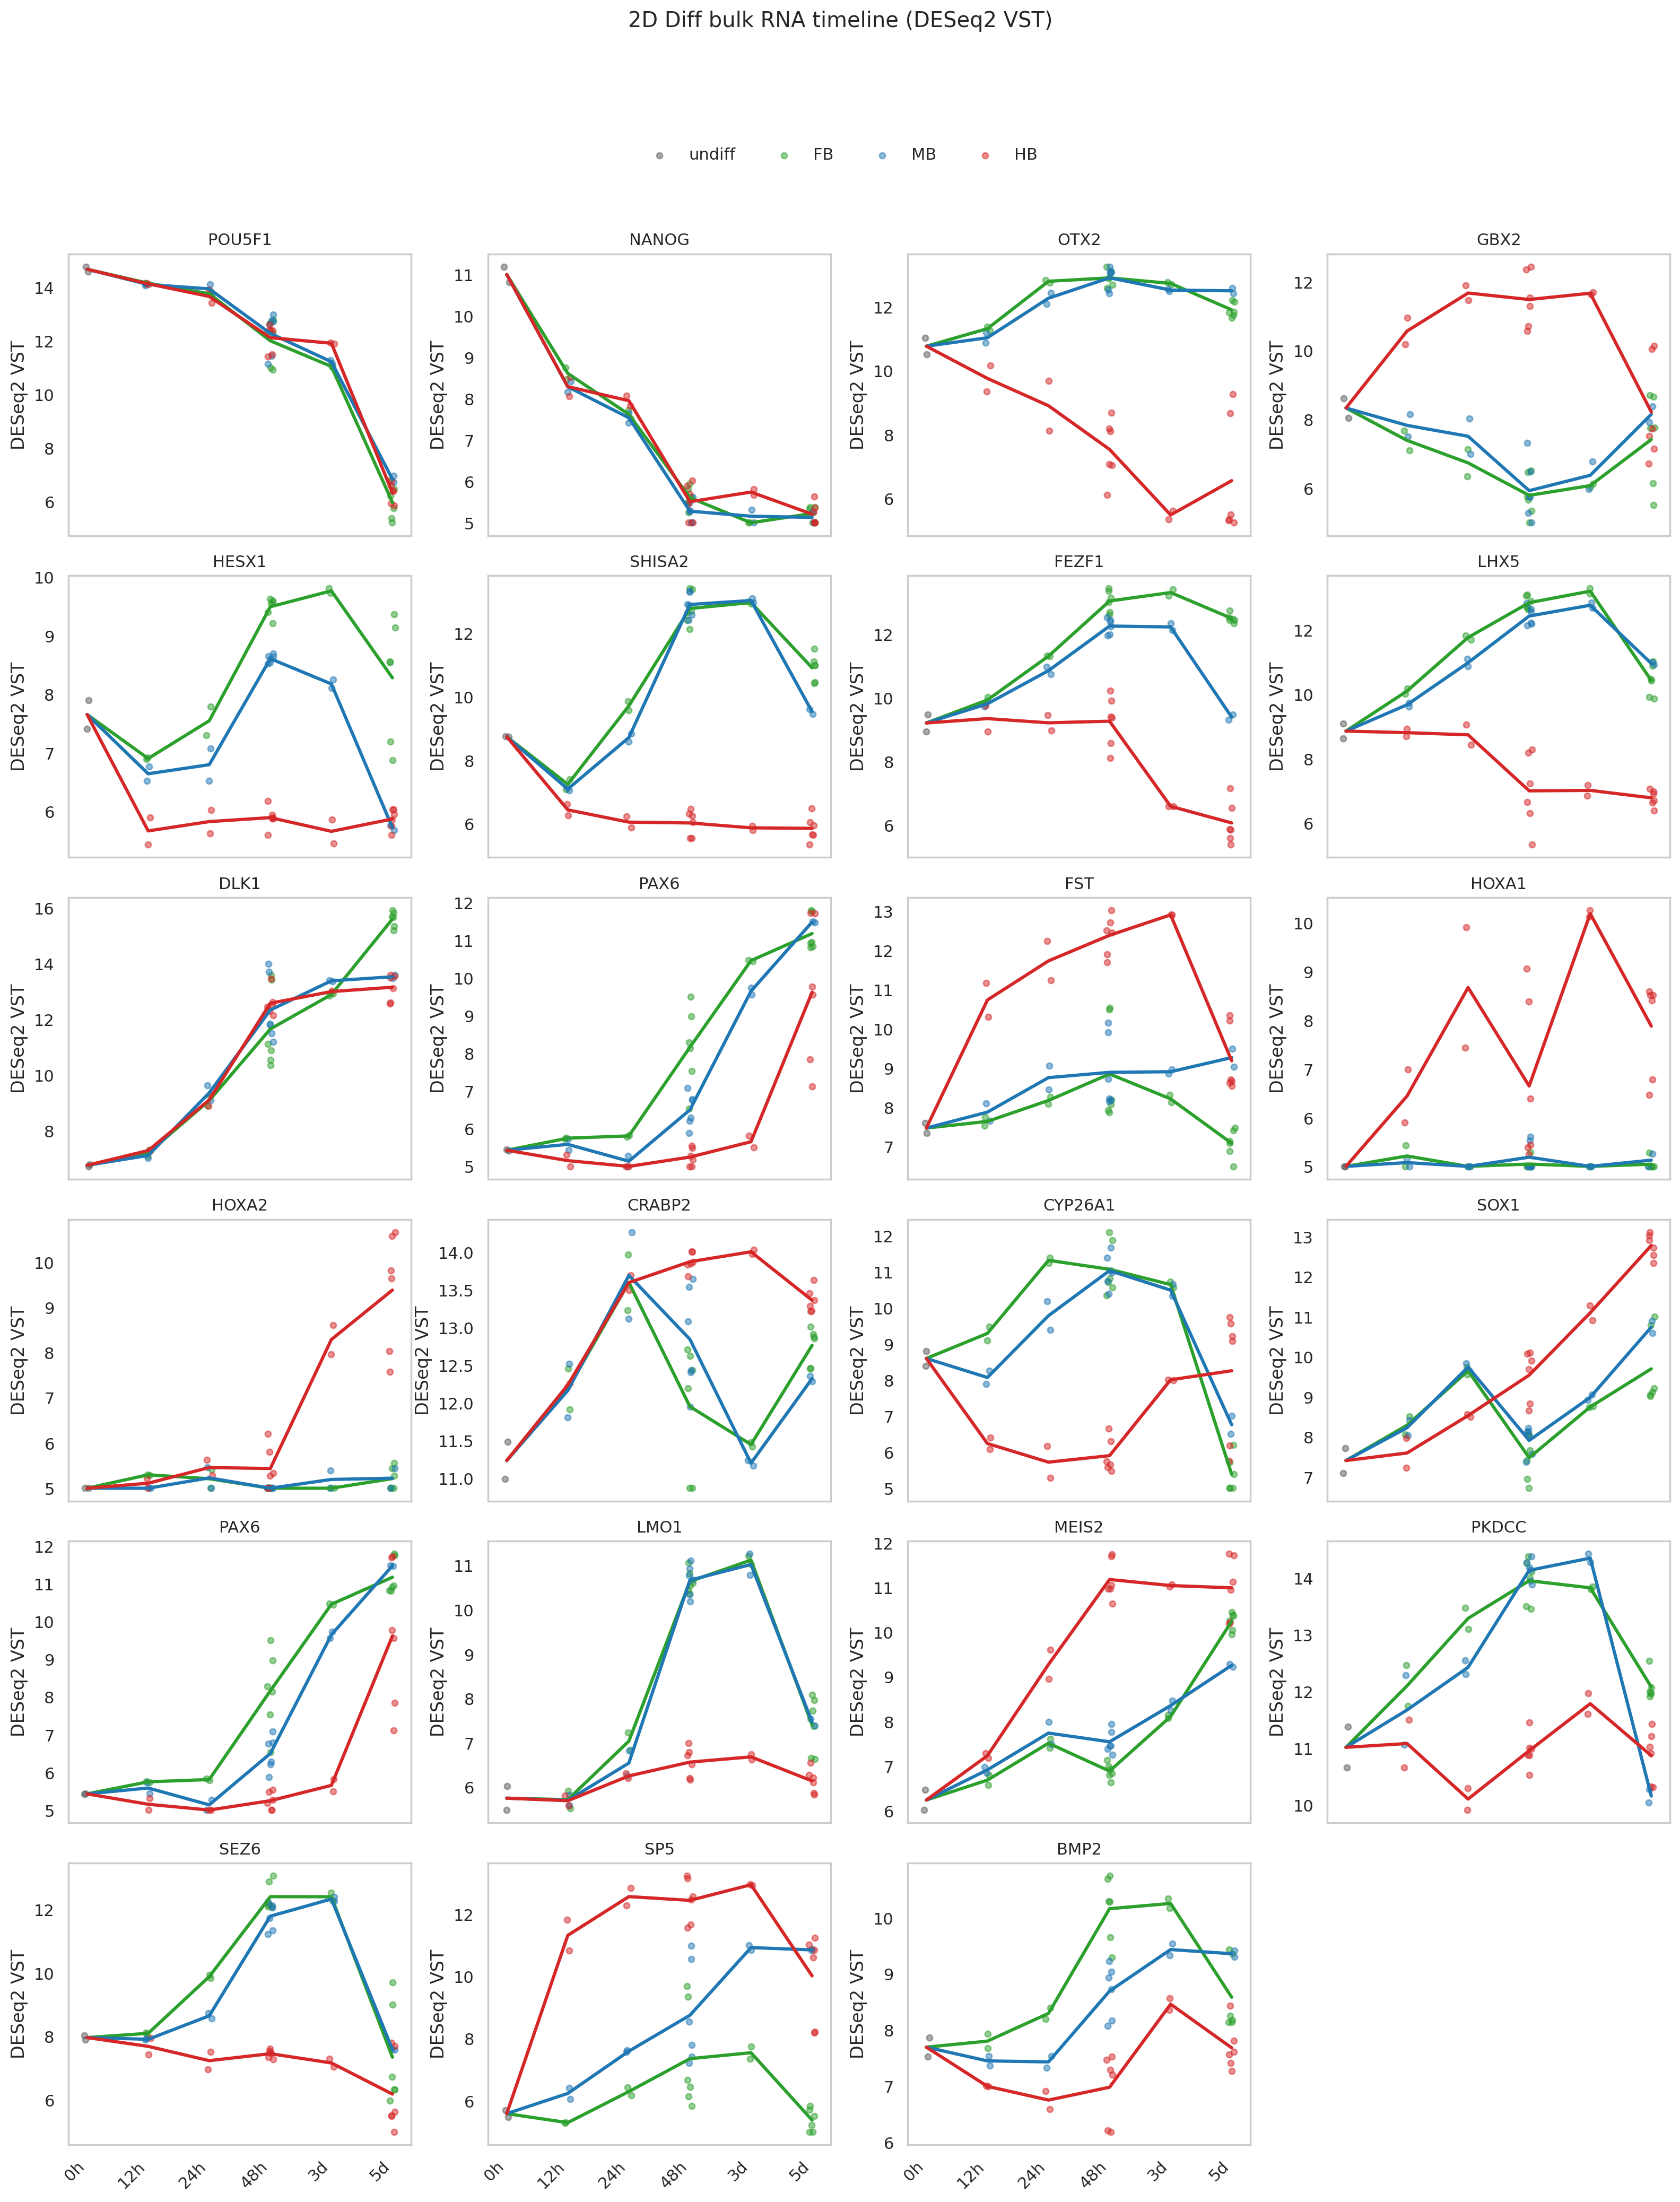

In [14]:
genes_to_plot = ["POU5F1", "NANOG", "OTX2", "GBX2", "HESX1", "SHISA2", "FEZF1", "LHX5", "DLK1", "PAX6", "FST", "HOXA1", "HOXA2", "CRABP2", "CYP26A1", "SOX1","PAX6", 'LMO1','MEIS2','PKDCC','SEZ6','SORB2','SP5','BMP2']

resolved, missing = resolve_genes(genes_to_plot, gene_map, allow_partial=True)
print("Resolved:", resolved)
if missing:
    print("Missing:", missing)


plot_gene_timelines(
    df_plot_0h,
    genes=resolved,
    time_order=TIME_ORDER_0H,
    fates=("undiff","FB","MB","HB"),#"MB"
    points_only_fates=("undiff",),
    ncols=4,
    save_path=str(OUTDIR / "RNA_timeline_with_0h_anchored_FB_HB.png"),
    suptitle="2D Diff bulk RNA timeline (DESeq2 VST)"
)

Resolved: ['POU5F1', 'NANOG', 'OTX2', 'GBX2', 'HESX1', 'SHISA2', 'FEZF1', 'LHX5', 'DLK1', 'PAX6', 'FST', 'HOXA1', 'HOXA2', 'CRABP2', 'CYP26A1', 'SOX1', 'PAX6', 'LMO1', 'MEIS2', 'PKDCC', 'SEZ6', 'SP5', 'BMP2']
Missing: ['SORB2']
Saved: /home/kgr851/BULK_RNA/timeline_plots/RNA_timeline_with_0h_anchored_FB_HB.png


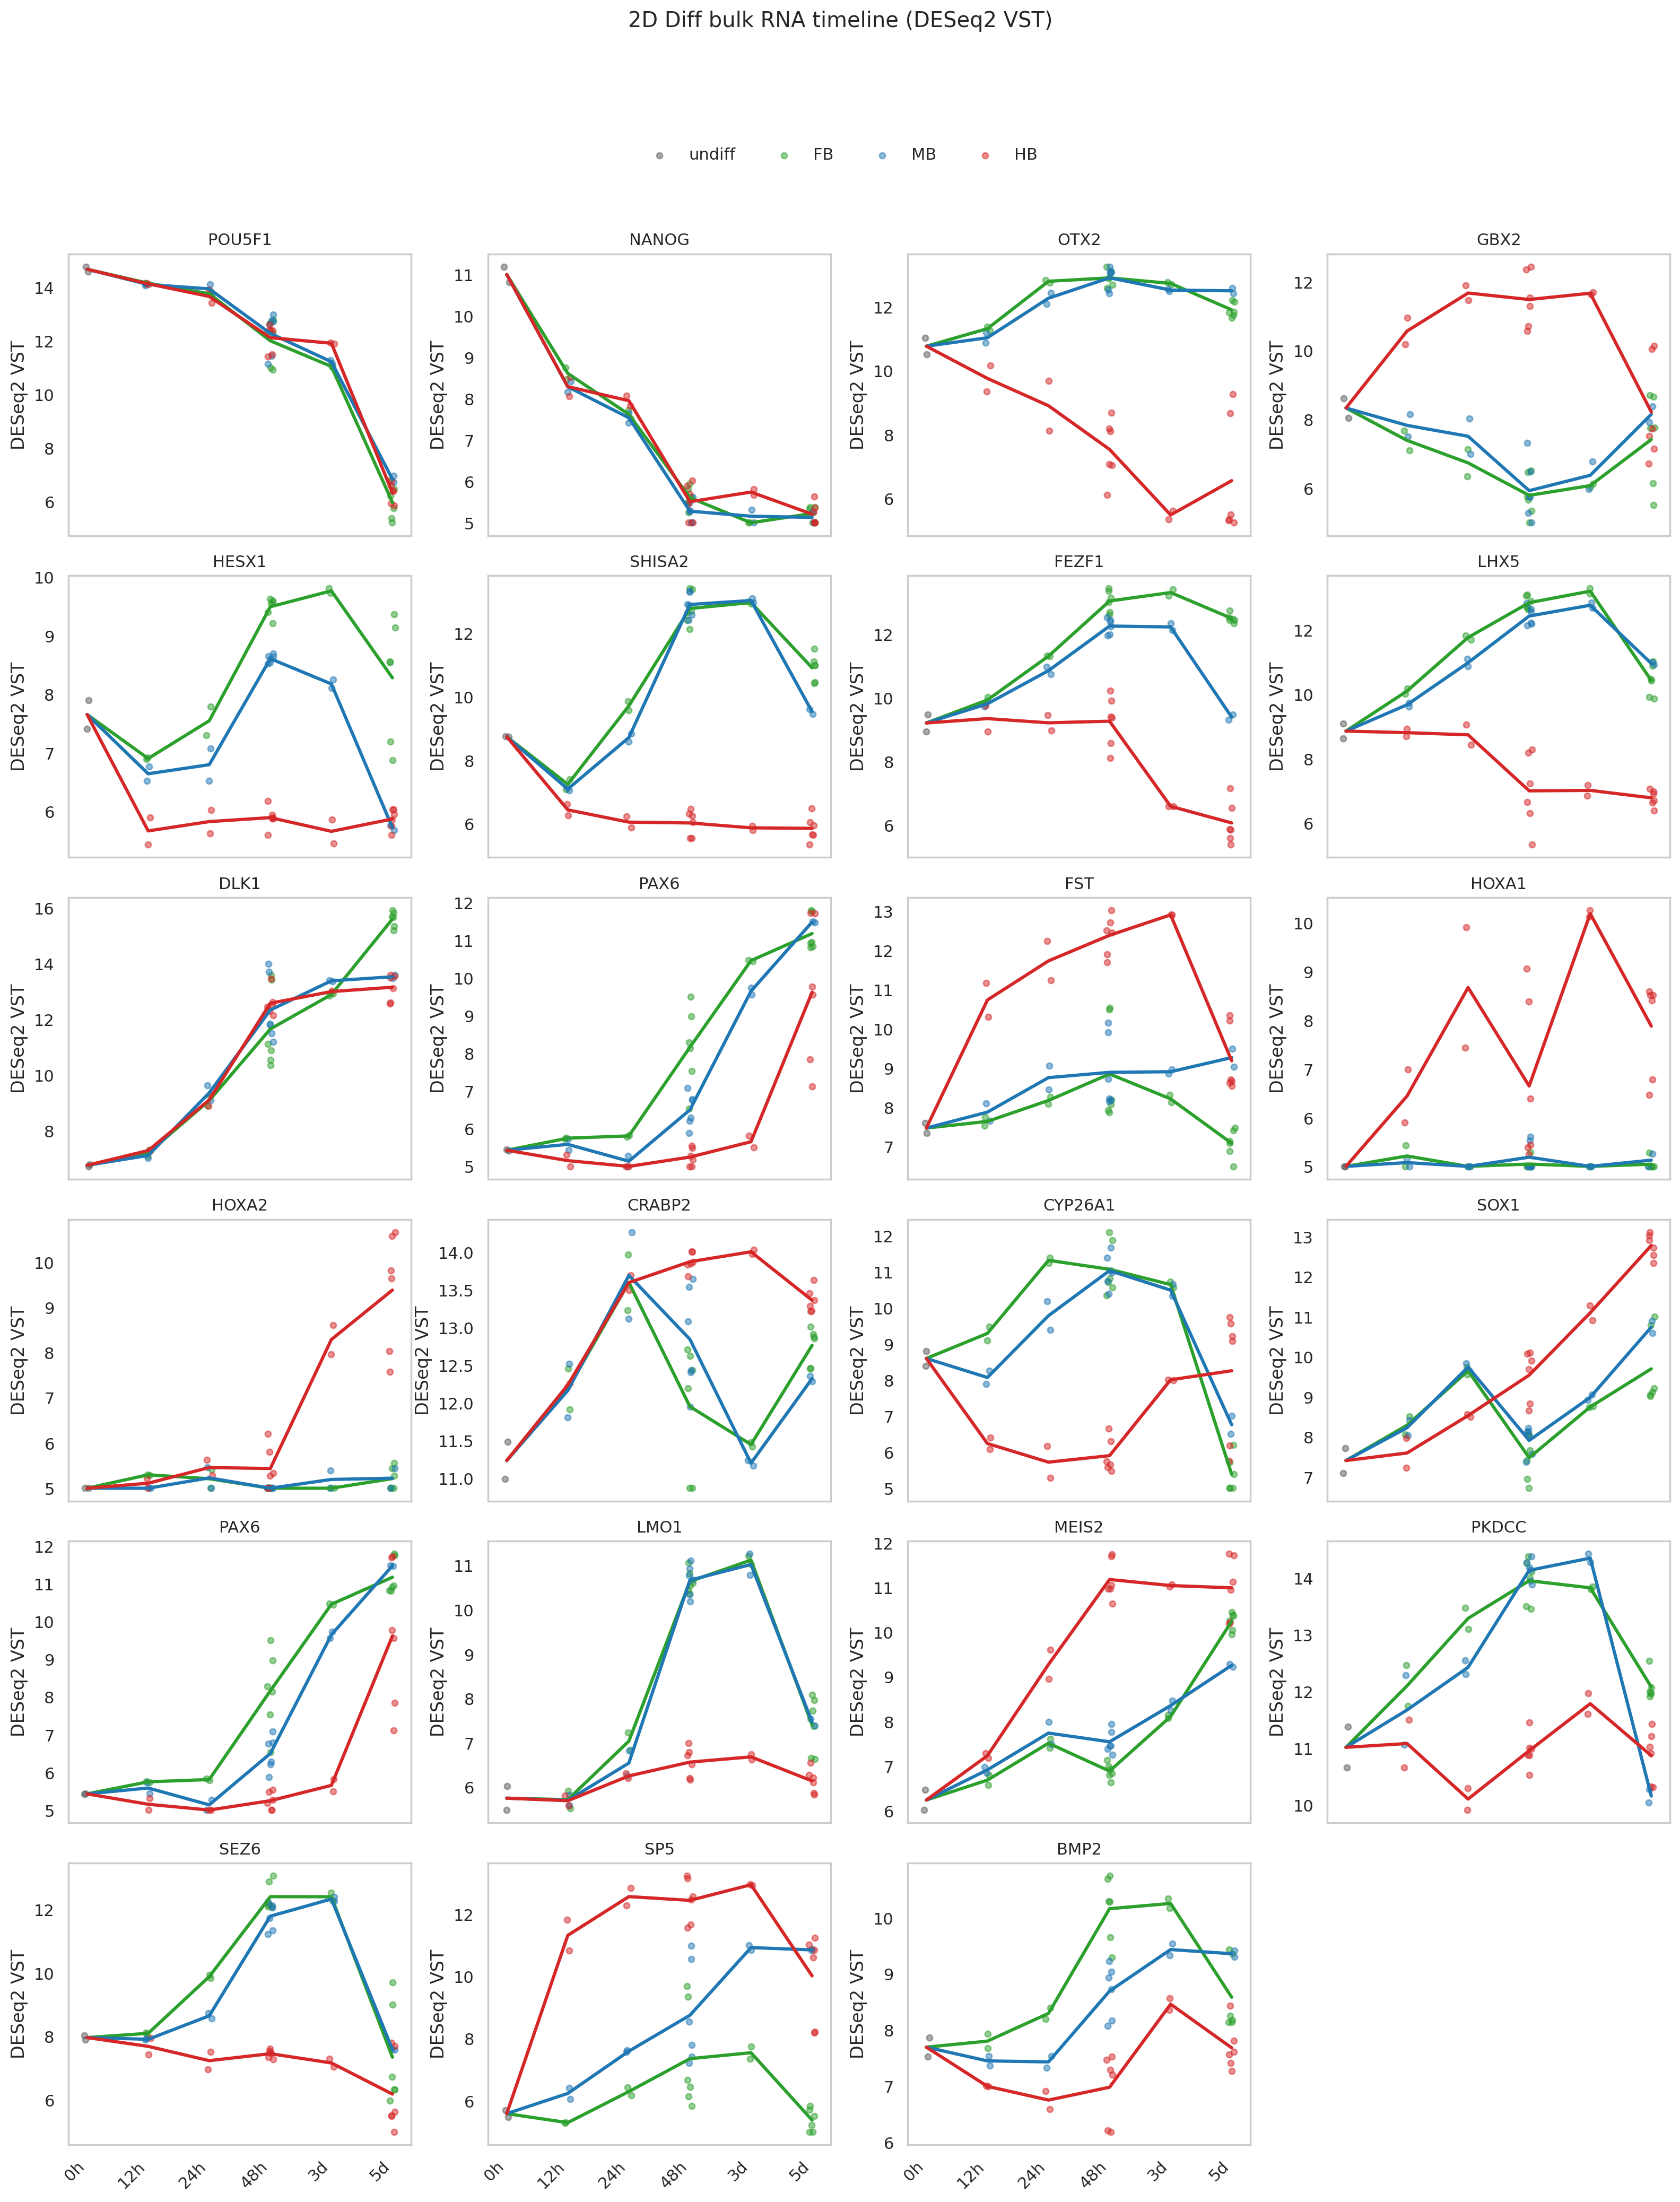

In [26]:
genes_to_plot = ["POU5F1", "NANOG", "OTX2", "GBX2", "HESX1", "SHISA2", "FEZF1", "LHX5", "DLK1", "PAX6", "FST", "HOXA1", "HOXA2", "CRABP2", "CYP26A1", "SOX1","PAX6", 'LMO1','MEIS2','PKDCC','SEZ6','SORB2','SP5','BMP2']

resolved, missing = resolve_genes(genes_to_plot, gene_map, allow_partial=True)
print("Resolved:", resolved)
if missing:
    print("Missing:", missing)


plot_gene_timelines(
    df_plot_0h,
    genes=resolved,
    time_order=TIME_ORDER_0H,
    fates=("undiff","FB","MB","HB"),#"MB"
    points_only_fates=("undiff",),
    ncols=4,
    save_path=str(OUTDIR / "RNA_timeline_with_0h_anchored_FB_HB.png"),
    suptitle="2D Diff bulk RNA timeline (DESeq2 VST)"
)